In [3]:
import os
os.chdir(r"C:\Users\Sidrcs\Documents\Github\Political_Polarization\data")

,nuts118cd,region_name,adm1_code,name,geometry
0,UKC,North East,UK-0,North East,"MULTIPOLYGON (((-0.79335 54.55831, -0.89818 54..."
1,UKD,North West,UK-1,North West,"POLYGON ((-2.17021 54.45820, -2.15900 54.47203..."
2,UKE,Yorkshire & Humber,UK-2,Yorkshire & Humber,"POLYGON ((0.01683 53.52586, -0.06185 53.58254,..."
3,UKF,East Midlands,UK-3,East Midlands,"POLYGON ((0.01683 53.52586, -0.06505 53.51874,..."
4,UKG,West Midlands,UK-4,West Midlands,"POLYGON ((-1.33190 52.16849, -1.31313 52.19047..."


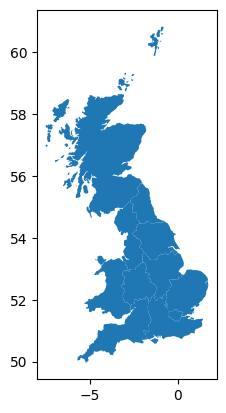

In [4]:
import geopandas as gpd
uk_gdf = gpd.read_file("UK_regions.geojson")
uk_gdf.plot()


uk_gdf = uk_gdf.rename(columns = {"nuts118nm" : "region_name"})
uk_gdf.head()

In [6]:
import pandas as pd
output_df_1995 = pd.read_csv("polarization1995_data.csv")
output_df_1995 = output_df_1995.rename(columns = {"nuts118nm" : "region_name"})

output_df_2000 = pd.read_csv("polarization2000_data.csv")
output_df_2000 = output_df_2000.rename(columns = {"nuts118nm" : "region_name"})

output_df_2004 = pd.read_csv("polarization2004_data.csv")
output_df_2004 = output_df_2004.rename(columns = {"nuts118nm" : "region_name"})

output_df_1995.head()

,Unnamed: 0,std_dev_age,native_share,education_variability,region_name,job_variability,frac_employed,median_income,gini_index,Lindqvist_Ostling_S1,Abramowitz_Saunders_S1,Duca_Saving_S1,Lindqvist_Ostling_S2,Abramowitz_Saunders_S2,Duca_Saving_S2,Lindqvist_Ostling_S3,Abramowitz_Saunders_S3,Duca_Saving_S3,admin1_code
0,0,18.929772,0.946183,399.0,East Midlands,399.0,0.446809,6427.445313,0.485968,0.843213,0.726141,1.394025,1.008246,0.852113,0.001214,1.131366,0.949153,1.878866,UK_3
1,1,18.511457,0.953883,411.5,East of England,411.5,0.470874,7721.132813,0.497099,0.853691,0.725131,1.004499,0.977064,0.828457,0.000922,1.089602,0.922667,2.041536,UK_5
2,2,17.650852,0.938341,445.5,London,445.5,0.487668,8279.160645,0.520353,0.858060,0.761139,0.376180,0.984581,0.873897,0.000884,1.188591,0.961929,3.195147,UK_6
3,3,18.640090,0.964623,211.5,North East,211.5,0.464623,6390.706543,0.455352,0.818051,0.719794,1.236752,0.978367,0.837270,0.001336,0.992494,0.950000,0.161722,UK_0
4,4,18.636682,0.955357,559.5,North West,559.5,0.468750,6927.100586,0.496123,0.880076,0.776119,0.954488,1.038682,0.899288,0.001155,1.091857,0.967280,1.398335,UK_1


In [8]:
merged_df_1995 = pd.merge(output_df_1995, uk_gdf[["region_name","adm1_code", "geometry"]], on = "region_name")
merged_df_1995 = merged_df_1995.drop(columns = ["Unnamed: 0"], axis = 1)

merged_gdf_1995 = gpd.GeoDataFrame(merged_df_1995, geometry = "geometry")

merged_df_2000 = pd.merge(output_df_2000, uk_gdf[["region_name","adm1_code", "geometry"]], on = "region_name")
merged_df_2000 = merged_df_2000.drop(columns = ["Unnamed: 0"], axis = 1)

merged_gdf_2000 = gpd.GeoDataFrame(merged_df_2000, geometry = "geometry")

merged_df_2004 = pd.merge(output_df_2004, uk_gdf[["region_name","adm1_code", "geometry"]], on = "region_name")
merged_df_2004 = merged_df_2004.drop(columns = ["Unnamed: 0"], axis = 1)

merged_gdf_2004 = gpd.GeoDataFrame(merged_df_2004, geometry = "geometry")

In [9]:
import libpysal as lps
import esda
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
y = merged_gdf_2000["Abramowitz_Saunders_S3"] # target variable
wq =  lps.weights.Queen.from_dataframe(merged_gdf_2000) # compute the spatial weights
wq.transform = 'r' # spatial weights require that the matrix is row-standardized 
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.12017935879645218

In [37]:
li = esda.moran.Moran_Local(y, wq)

In [38]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [39]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

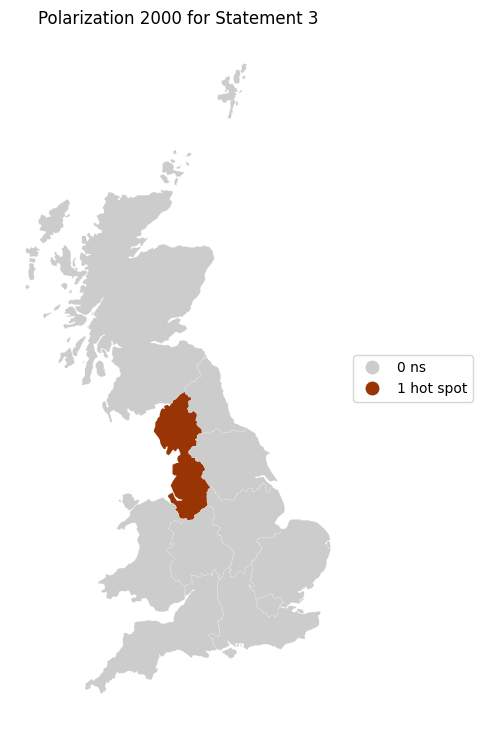

In [40]:
df = merged_gdf_2000
from matplotlib import colors
hmap = colors.ListedColormap(['#ccc','#a63603','#fe9929','#feedde','#993404'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.set_axis_off()
plt.title(f"Polarization 2000 for Statement 3")
plt.show()

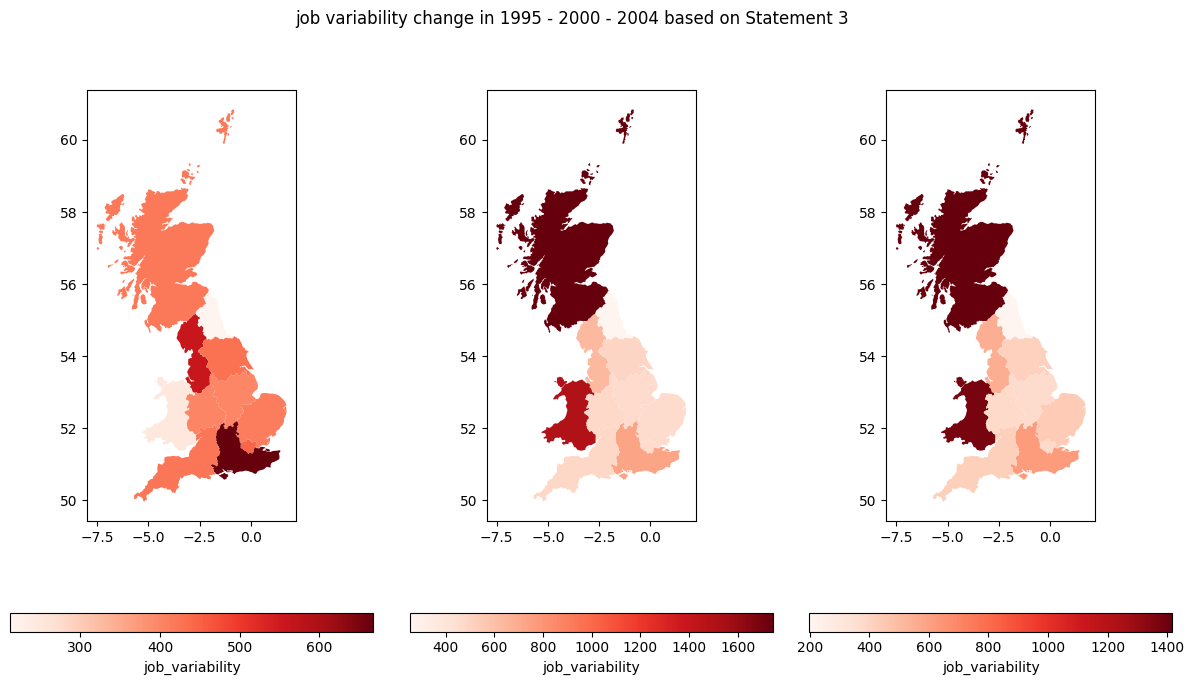

In [46]:
import matplotlib.pyplot as plt

# create one row, multiple columns of sub-figures
fig, ax = plt.subplots(1, 3, figsize=(15, 8)) 
# adjust horizontal space between subplots
fig.subplots_adjust(wspace=0.1) 

# creating various plots using statement S3: It is the government’s responsibility to provide a job for everyone who wants one.

merged_gdf_1995.plot(ax=ax[0], column='job_variability', cmap='Reds', legend=True, \
                     legend_kwds={'label': "job_variability", 'orientation': "horizontal"})
merged_gdf_2000.plot(ax=ax[1],  column='job_variability', cmap='Reds', legend=True, \
                     legend_kwds={'label': "job_variability",'orientation': "horizontal"})
merged_gdf_2004.plot(ax=ax[2],  column='job_variability', cmap='Reds', legend=True, \
         legend_kwds={'label': "job_variability", 'orientation': "horizontal"})

plt.suptitle("job variability change in 1995 - 2000 - 2004 based on Statement 3")
plt.show()

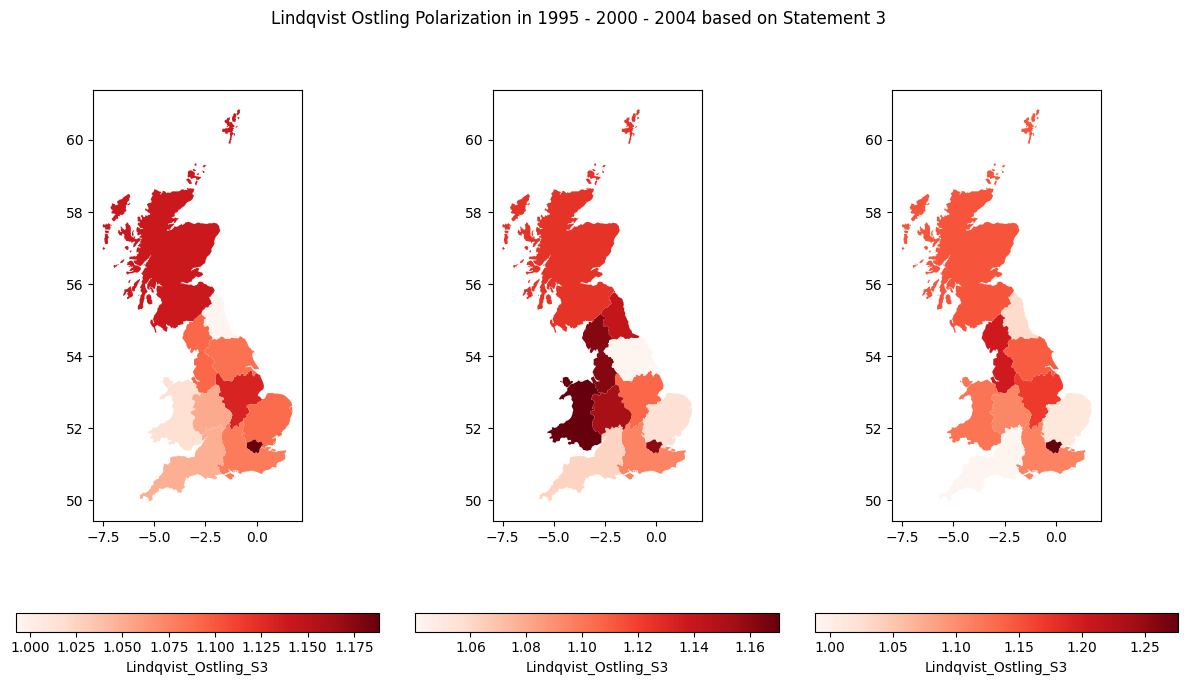

In [42]:
import matplotlib.pyplot as plt

# create one row, multiple columns of sub-figures
fig, ax = plt.subplots(1, 3, figsize=(15, 8)) 
# adjust horizontal space between subplots
fig.subplots_adjust(wspace=0.1) 

# creating various plots using statement S3: It is the government’s responsibility to provide a job for everyone who wants one.

merged_gdf_1995.plot(ax=ax[0], column='Lindqvist_Ostling_S3', cmap='Reds', legend=True, \
                     legend_kwds={'label': "Lindqvist_Ostling_S3", 'orientation': "horizontal"})
merged_gdf_2000.plot(ax=ax[1],  column='Lindqvist_Ostling_S3', cmap='Reds', legend=True, \
                     legend_kwds={'label': "Lindqvist_Ostling_S3",'orientation': "horizontal"})
merged_gdf_2004.plot(ax=ax[2],  column='Lindqvist_Ostling_S3', cmap='Reds', legend=True, \
         legend_kwds={'label': "Lindqvist_Ostling_S3", 'orientation': "horizontal"})

plt.suptitle("Lindqvist Ostling Polarization in 1995 - 2000 - 2004 based on Statement 3")
plt.show()

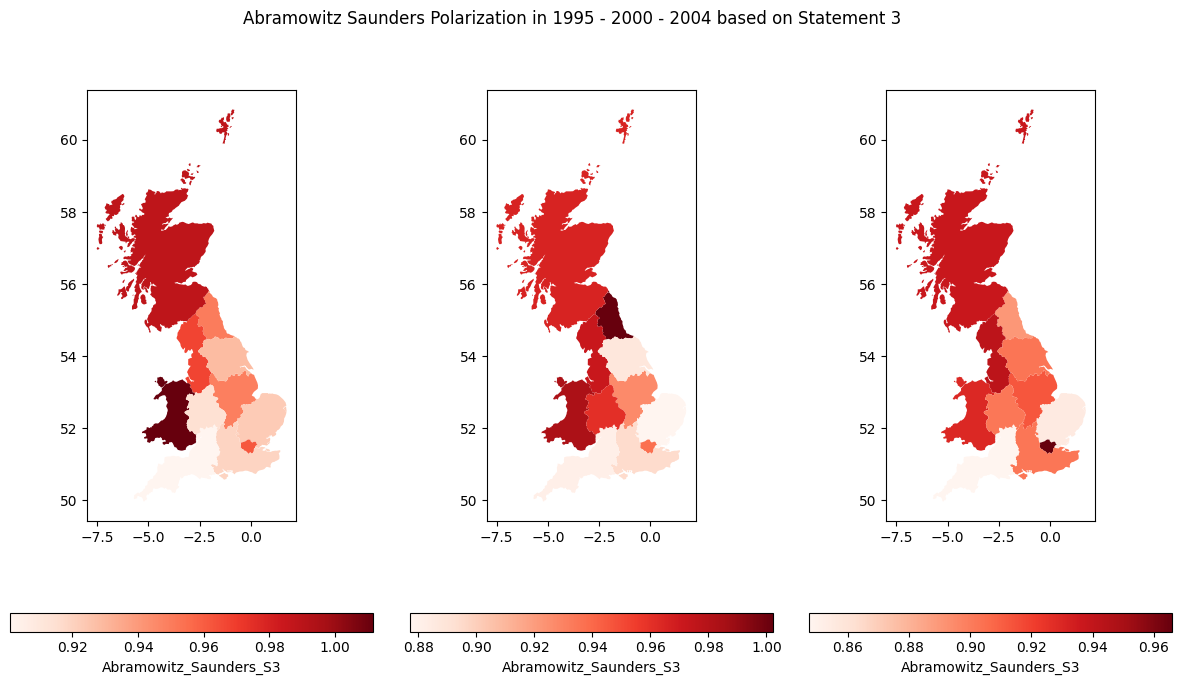

In [44]:
import matplotlib.pyplot as plt

# create one row, multiple columns of sub-figures
fig, ax = plt.subplots(1, 3, figsize=(15, 8)) 
# adjust horizontal space between subplots
fig.subplots_adjust(wspace=0.1) 

# creating various plots using statement S3: It is the government’s responsibility to provide a job for everyone who wants one.

merged_gdf_1995.plot(ax=ax[0], column='Abramowitz_Saunders_S3', cmap='Reds', legend=True, \
                     legend_kwds={'label': "Abramowitz_Saunders_S3", 'orientation': "horizontal"})
merged_gdf_2000.plot(ax=ax[1],  column='Abramowitz_Saunders_S3', cmap='Reds', legend=True, \
                     legend_kwds={'label': "Abramowitz_Saunders_S3",'orientation': "horizontal"})
merged_gdf_2004.plot(ax=ax[2],  column='Abramowitz_Saunders_S3', cmap='Reds', legend=True, \
         legend_kwds={'label': "Abramowitz_Saunders_S3", 'orientation': "horizontal"})

plt.suptitle("Abramowitz Saunders Polarization in 1995 - 2000 - 2004 based on Statement 3")
plt.show()

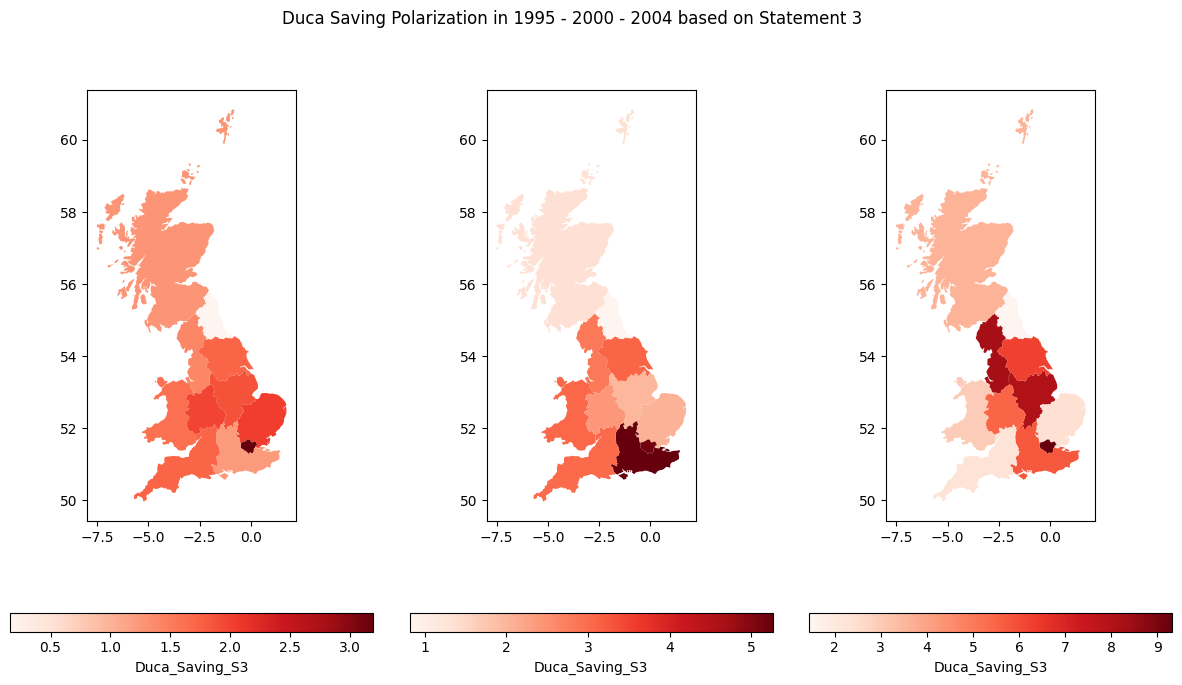

In [45]:
import matplotlib.pyplot as plt

# create one row, multiple columns of sub-figures
fig, ax = plt.subplots(1, 3, figsize=(15, 8)) 
# adjust horizontal space between subplots
fig.subplots_adjust(wspace=0.1) 

# creating various plots using statement S3: It is the government’s responsibility to provide a job for everyone who wants one.

merged_gdf_1995.plot(ax=ax[0], column='Duca_Saving_S3', cmap='Reds', legend=True, \
                     legend_kwds={'label': "Duca_Saving_S3", 'orientation': "horizontal"})
merged_gdf_2000.plot(ax=ax[1],  column='Duca_Saving_S3', cmap='Reds', legend=True, \
                     legend_kwds={'label': "Duca_Saving_S3",'orientation': "horizontal"})
merged_gdf_2004.plot(ax=ax[2],  column='Duca_Saving_S3', cmap='Reds', legend=True, \
         legend_kwds={'label': "Duca_Saving_S3", 'orientation': "horizontal"})

plt.suptitle("Duca Saving Polarization in 1995 - 2000 - 2004 based on Statement 3")
plt.show()